# Loan Prediction Model

## Machine Learning ALP - Hagen Kwik & Dhammiko Dharmawan

## Setup

### Import Libraries

In [1]:
# library for mathematical functions and data preprocessing such as table, etc
import pandas as pd
import numpy as np
from scipy.stats import skew

# Library for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# Library for machine learning functions/algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

### Load Dataset

In [9]:
# data itself
url = 'lending_club_loan_two.csv'
# description of each column
url_info = 'lending_club_info.csv'
df_before = pd.read_csv(url)
df_info = pd.read_csv(url_info)
df_before.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [256]:
# Check which column needs fixing
for column in df_before.columns:
    unique_values = df_before[column].unique()
    print(f"Unique values in '{column}':")
    print(unique_values)
    print()

Unique values in 'loan_amnt':
[10000.  8000. 15600. ... 36275. 36475.   725.]

Unique values in 'term':
[' 36 months' ' 60 months']

Unique values in 'int_rate':
[11.44 11.99 10.49  6.49 17.27 13.33  5.32 11.14 10.99 16.29 13.11 14.64
  9.17 12.29  6.62  8.39 21.98  7.9   6.97  6.99 15.61 11.36 13.35 12.12
  9.99  8.19 18.75  6.03 14.99 16.78 13.67 13.98 16.99 19.91 17.86 21.49
 12.99 18.54  7.89 17.1  18.25 11.67  6.24  8.18 12.35 14.16 17.56 18.55
 22.15 10.39 15.99 16.07 24.99  9.67 19.19 21.   12.69 10.74  6.68 19.22
 11.49 16.55 19.97 24.7  13.49 18.24 16.49 25.78 25.83 18.64  7.51 13.99
 15.22 15.31  7.69 19.53 10.16  7.62  9.75 13.68 15.88 14.65  6.92 23.83
 10.75 18.49 20.31 17.57 27.31 19.99 22.99 12.59 10.37 14.33 13.53 22.45
 24.5  17.99  9.16 12.49 11.55 17.76 28.99 23.1  20.49 22.7  10.15  6.89
 19.52  8.9  14.3   9.49 25.99 24.08 13.05 14.98 16.59 11.26 25.89 14.48
 21.99 23.99  5.99 14.47 11.53  8.67  8.59 10.64 23.28 25.44  9.71 16.2
 19.24 24.11 15.8  15.96 14.49 18.99

### Fix Data

In [10]:
# Create a new DataFrame for 'issue_d'
df_before_issue = df_before['issue_d'].str.split('-', expand=True)
df_before_issue.columns = ['issue_month', 'issue_year']

# Create a new DataFrame for 'earliest_cr_line'
df_before_cr_line = df_before['earliest_cr_line'].str.split('-', expand=True)
df_before_cr_line.columns = ['cr_line_month', 'cr_line_year']

# Concatenate the new DataFrames with the original DataFrame
df_before_issue['issue_year'] = pd.to_numeric(df_before_issue['issue_year'])
df_before_cr_line['cr_line_year'] = pd.to_numeric(df_before_cr_line['cr_line_year'])

# Calculate the difference between the issue year and cr line year
df_before['years_since_cr_line'] = df_before_issue['issue_year'] - df_before_cr_line['cr_line_year']

In [11]:
df_before

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,years_since_cr_line
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",25
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",11
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",8
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",8
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60 months,10.99,217.38,B,B4,licensed bankere,2 years,RENT,40000.0,...,0.0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0,"12951 Williams Crossing\nJohnnyville, DC 30723",11
396026,21000.0,36 months,12.29,700.42,C,C1,Agent,5 years,MORTGAGE,110000.0,...,0.0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0,"0114 Fowler Field Suite 028\nRachelborough, LA...",9
396027,5000.0,36 months,9.99,161.32,B,B1,City Carrier,10+ years,RENT,56500.0,...,0.0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0,"953 Matthew Points Suite 414\nReedfort, NY 70466",16
396028,21000.0,60 months,15.31,503.02,C,C2,"Gracon Services, Inc",10+ years,MORTGAGE,64000.0,...,0.0,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0,"7843 Blake Freeway Apt. 229\nNew Michael, FL 2...",22


### Remove Useless Columns

In [12]:
# Reason:
# These features lack direct relevance to a person's ability to secure a loan. 
# grade and subgrade, summarizes the loan status, can be substituted with existing data like interest rates and annual income

columns_to_drop = ['emp_title', 'address', 'title', 'earliest_cr_line', 'issue_d', 'grade', 'sub_grade', 'purpose','initial_list_status']
df_before = df_before.drop(columns=columns_to_drop)

### Label Encoding (LOAN STATUS GA HARUS DI ENCODE)

In [13]:
# label encoder and fit_transform is a function that changes/remap string into number based on alphabetical order
le = LabelEncoder() 
df_before['term'] = le.fit_transform(df_before['term'])
# 36 months = 0,  60 months = 1

df_before['emp_length'] = le.fit_transform(df_before['emp_length'])
# '1 year' = 0, '10+ years' = 1, '2 years' = 2, '3 years' = 3, '4 years' = 4, '5 years' = 5,   
# '6 years' = 6, '7 years' = 7, '8 years' = 8,  '9 years' = 9, '< 1 year' = 10

df_before['home_ownership'] = le.fit_transform(df_before['home_ownership'])
# 'ANY' = 0, 'MORTGAGE' = 1, 'NONE' = 2, 'OTHER' = 3, 'OWN' = 4, 'RENT' = 5

df_before['verification_status'] = le.fit_transform(df_before['verification_status'])
# 'Not Verified' = 0, 'Source Verified' = 1, 'Verified' = 2

df_before['loan_status'] = le.fit_transform(df_before['loan_status'])
# 'Charged Off' = 0, 'Fully Paid' = 1 

df_before['application_type'] = le.fit_transform(df_before['application_type'])
# 'DIRECT_PAY' = 0, 'INDIVIDUAL' = 1, 'JOINT' = 2

In [14]:
df_before['emp_length'].fillna(df_before['emp_length'].median(), inplace=True)
df_before['pub_rec_bankruptcies'].fillna(df_before['pub_rec_bankruptcies'].median(), inplace=True)
df_before['mort_acc'].fillna(df_before['mort_acc'].median(), inplace=True)
df_before['revol_util'].fillna(df_before['revol_util'].mean(), inplace=True)

In [15]:
z_score_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc']

no_outlier = df_before.copy()

# Store outlier counts and percentages for each column
outlier_info = {}

for col in z_score_vars:
    # since our dataset is skewed we use the 99 percentile formula to detect and delete outliers, only identifying extreme datas
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)

    # Count outliers before clipping
    outlier_count = ((df_before[col] < lower_limit) | (df_before[col] > upper_limit)).sum()
    total_count = len(df_before[col])
    outlier_percentage = outlier_count / total_count * 100

    # Store outlier information for the column
    outlier_info[col] = {'count': outlier_count, 'percentage': outlier_percentage}

# Print outlier information for each column
print("Outlier information:")
for col, info in outlier_info.items():
    print(f"- {col}: {info['count']} outliers ({info['percentage']:.2f}%)")

# Drop rows with outliers
for col in z_score_vars:
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)
    no_outlier = no_outlier[(no_outlier[col] >= lower_limit) & (no_outlier[col] <= upper_limit)]

Outlier information:
- loan_amnt: 4089 outliers (1.03%)
- int_rate: 7823 outliers (1.98%)
- installment: 7916 outliers (2.00%)
- annual_inc: 7237 outliers (1.83%)
- dti: 7905 outliers (2.00%)
- open_acc: 5372 outliers (1.36%)
- pub_rec: 2543 outliers (0.64%)
- revol_bal: 7918 outliers (2.00%)
- total_acc: 7553 outliers (1.91%)


## Random Forest Classification (Model Generation)

In [16]:
#  SPLIT
target_column = 'loan_status'
feature_columns = no_outlier.columns[no_outlier.columns != target_column]

X = no_outlier[feature_columns]
y = no_outlier[target_column]

In [17]:
# use the pareto priuncple 

# Split data into training (80%) and temporary set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Over and Under sampling / Rebalance Training Dataset

In [18]:
X_train_resampled, y_train_resampled = SMOTEENN(sampling_strategy='all', enn=EditedNearestNeighbours(sampling_strategy='all')).fit_resample(X_train, y_train)

#### Check dataset after rebalancing

In [19]:
data = y_train.value_counts()
print(data)

loan_status
1    225416
0     54117
Name: count, dtype: int64


In [20]:
data_counts = y_train_resampled.value_counts()
print(data_counts)

loan_status
0    125728
1     99453
Name: count, dtype: int64


In [21]:
# Hyper Paramaters:
# n estimator (value to be determined by using a for loop while checking  accuracy score)
# bootstrap value true (to validate test result by using selecting random data)
# criterion value gini (Computational Efficiency as we have a large dataset and is less sensitive to outliers)
# max depth value none( to use all variables as it is currently not overfitting)
# max features value all/auto (use all to diversify tree, create more robust)

clf = RandomForestClassifier(n_estimators=83, bootstrap=True, criterion='gini', max_depth=None,  random_state=0)

# Train the classifier on the training set
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_test = clf.predict(X_test)

# Evaluate the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy_test}')


Test Accuracy: 0.7453780550626753


## Evaluation

### Confusion Matrix

In [22]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix\n", cm)

Confusion Matrix
 [[ 5011  8628]
 [ 9166 47079]]


In [23]:
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

 Charged Off       0.35      0.37      0.36     13639
  Fully Paid       0.85      0.84      0.84     56245

    accuracy                           0.75     69884
   macro avg       0.60      0.60      0.60     69884
weighted avg       0.75      0.75      0.75     69884



In [24]:
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
2,int_rate,0.162112
15,mort_acc,0.106261
6,annual_inc,0.083321
8,dti,0.072936
0,loan_amnt,0.066208
3,installment,0.061556
11,revol_bal,0.058618
5,home_ownership,0.058377
9,open_acc,0.056271
12,revol_util,0.055063


### F1 Score

In [25]:
TN, FP, FN, TP = cm.ravel()

# Calculate Accuracy
# (TP+TN)/total sample
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate Precision
# TP/(TP+FP)
# Precision is a measure of the accuracy of positive predictions made by the model. It answers the question: "Of all the instances predicted as positive, how many were actually positive?"
precision = precision_score(y_test, y_pred_test)
print("Precision:", precision)

# Calculate Recall
# TP/(TP+FN)
# Recall measures the model's ability to identify all the positive instances correctly. It answers the question: "Of all the actual positive instances, how many were correctly predicted?"
recall = recall_score(y_test, y_pred_test)
print("Recall:", recall)

# Calculate Specificity
# TN/(TN+FN)
# specificity measures the model's ability to identify negative instances correctly. It answers the question: "Of all the actual negative instances, how many were correctly predicted?"
specificity = TN / (TN + FP)
print("Specificity:", specificity)

# Calculate F1 Score
# (2*Precision*Recall)/(Precision+Recall)
f1 = f1_score(y_test, y_pred_test)
print("F1 Score:", f1)

Accuracy: 0.7453780550626753
Precision: 0.8451182077656308
Recall: 0.8370344030580497
Specificity: 0.3674023022215705
F1 Score: 0.8410568815206517


### AUC Score

AUC Score: 0.6836530579404305


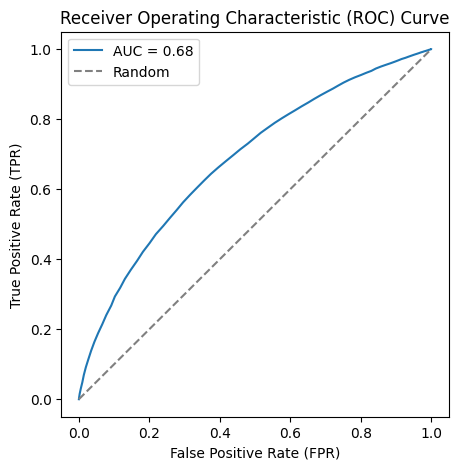

In [26]:
# Assuming you have the predicted probabilities for the positive class
y_prob_test = clf.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_test)
print("AUC Score:", auc_score)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

# is 69 auc score good what does it mean, what can i do to increase it?